# 전복 나이 예측 경진대회 베이스라인 2차

이번 베이스라인에서는 다양한 모델을 학습 시켜보고, 모델들을 앙상블(Ensemble)하여 추론하는 것을 진행해보겠습니다.

# 1. 학습 데이터 불러오기

먼저 분석하려는 데이터를 작업장으로 가져오는 작업이 필요합니다.

이를 위해서 파이썬 라이브러리 중 하나인 Pandas를 이용합니다.

pandas 라이브러리는 엑셀과 같은 행과 열로 이루어진 테이블(table) 형식의 데이터를 편하게 다루도록 해주는 라이브러리입니다.

데이터 분석에는 반드시 사용된다고 해도 과언이 아닌 라이브러리이니, 시간이 날때마다 공부해둡시다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

# csv형식으로 된 데이터 파일을 읽어옵니다.
train_df = pd.read_csv('./dataset/train.csv')
train_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


데이터를 더 자세히 살펴보는 것은 EDA 글을 통해 더 자세히 배워봅시다.

여기에는 분석 방법에 초점을 맞추겠습니다.

# 2. 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [2]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train_df)

결측치가 존재하지 않습니다


이번 데이터에는 결측치가 존재하지 않습니다.

# 3. 데이터 전처리

## 데이터 인코딩
머신러닝 알고리즘은 문자열 데이터 속성을 입력받지 않으며 모든 데이터는 숫자형으로 표현되어야 합니다.

그래서 문자형 카테고리형 속성은 모두 숫자 값으로 변환/인코딩 되어야 합니다.

이번에 적용해볼 인코딩 방식은 'Label Encoding' 입니다.

Label Encoding이란, 범주형 변수의 문자열을 수치형으로 변환하는 방법 중 하나입니다.

우리 데이터에는 Gender라는 Feautre의 항목이 문자로 이루어져있기 때문에, 이것을 Label Encoding을 통해 숫자형으로 표현해보겠습니다.

In [3]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    print(label_maps)
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

In [4]:
train_le = make_label_map(train_df[['Gender']])
gender_df = label_encoder(train_df[['Gender']], train_le)
train_df['Gender'] = gender_df[['Gender']]

{'Gender': {'unknown': 0, 'M': 1, 'I': 2, 'F': 3}}


다음과 같이 Label Encoding을 통해서 Gender에 해당하는 데이터들이 모두 숫자형으로 변환됨을 확인할 수 있습니다.

다시말하자면, Gender 부분의 데이터에서 결측치는 0, M은 1, I는 2, F는 3으로 변환해주었습니다.

그리고 본격적으로 모델 학습을 위해 학습 데이터와 Target을 분리합니다. 

In [5]:
train_x = train_df.drop(['id', 'Target'], axis=1)
train_y = train_df.Target

# 4. 다양한 모델 선언과 학습

먼저, 1차로 제공해드린 베이스라인에서는 RandomForest에 대해서 알아보았으며 sklearn 패키지에서 제공하는 RandomForestRegressor를 사용했었습니다.

이번에는 RandomForest 모델을 비롯해 좀 더 다양한 모델들도 같이 학습을 시켜보겠습니다.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(RandomForestRegressor(random_state=32))
models.append(LinearRegression())
models.append(GradientBoostingRegressor(learning_rate=0.06, criterion='mae', random_state=32))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_x, train_y)

# 6. 앙상블 추론 (Inference)

모델 학습이 완료되었다면, 이제 test 데이터를 통하여 전복나이를 본격적으로 앙상블 기법을 활용하여 예측해보겠습니다.

In [7]:
# csv형식으로 된 데이터 파일을 읽어옵니다.
test_df = pd.read_csv('./dataset/test.csv')
test_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,F,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550
1,2,M,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600
2,3,I,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305
3,4,M,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300
4,5,F,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050


학습 데이터에 했던 전처리 과정(Label인코딩)을 테스트 데이터에도 해줍니다.

단, 학습 데이터에 학습된 인코더를 사용해 주어야 합니다.

(테스트 데이터를 학습 시킨 인코더를 사용하면 data leakage 에 해당됩니다!)

In [8]:
gender_df = label_encoder(test_df[['Gender']], train_le)
test_df['Gender'] = gender_df[['Gender']]

test_df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,3,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550
1,2,1,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600
2,3,2,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305
3,4,1,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300
4,5,3,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050


In [9]:
test_x = test_df.drop(['id'],axis=1)

## Ensemble (앙상블)

이번 베이스라인에서는 단일 모델에서 나오는 성능의 결과를 기대하는 것이 아니라,

여러 개의 단일 모델들의 평균치를 내거나(Soft-Voting), 투표를 해서 다수결에 의한 결정(Hard-Voting)을 하는 등
여러 모델들의 '집단 지성'을 활용하여 더 나은 결과를 도출해 내는 것에 목적이 있습니다.

## 왜 Ensemble (앙상블)이 더 나은 결과를 도출해내는가?

왜 여러 모델들의 '집단 지성'을 활용한다면 더 나은 결과를 기대할 수 있을까요?

일반적으로 우리는 모델을 학습시킬 때, 이상적으로 아래의 그림에서 분산과 편향이 모두 낮은 모델을 기대합니다.<br>
하지만 현실은 대부분의 모델이 낮은 분산, 높은 편향 또는 높은 분산, 낮은 편향을 가지는 경우가 많습니다.<br>
따라서 이 두 가지의 유형에서 이상적인 분산과 편향이 모두 낮은 모델로 만들기 위한 노력이 바로 앙상블입니다.

즉, 앙상블의 목적은 다중 학습 모델을 기반으로 분산 또는 편향의 감소를 통해 전체 에러를 줄이는 것입니다.

하지만 무조건 앙상블이 항상 더 나은 성능을 내는 것은 아닙니다.<br>
앙상블이 효과를 보기 위해서는 몇가지 조건이 있습니다.<br>

- 각각 모델들이 충분한 수준의 '다양성'을 가지도록 한다.

같은 데이터셋과 같은 모델, 같은 학습 방법을 사용하여 여러 개의 모델을 만들어 앙상블을 시도해도<br>
각각의 모델들은 모두 같은 결과를 낼 것이기 때문에 결국 분산과 편향을 감소할 수 없을 것입니다.<br>
예를 들어, RandomForest와 같은 앙상블 베이스 모델의 경우에 Bagging을 활용하여 다양성을 가지는 Decision Tree들의 앙상블의 효과를 기대하는 것과 같습니다.<br>

- 각각 모델들이 모두 최소한의 성능은 발휘할 수 있어야 한다.

아래의 그림에서 학습시킨 모델이 모두 높은 편향과 분산을 가지는 성능이라면, 이는 앙상블을 시도해도 결국 성능 향상으로 이어지기 힘들 것입니다.<br>

- 각각 모델들의 결과물을 잘 결합한다.

결국 앙상블의 목적은 아래의 그림에서의 낮은 편향과 분산을 가지는 최종 결과를 얻는 것에 목적이 있습니다.<br>
따라서 이러한 목적으로 가기 위해 각각의 모델들의 결과물들을 잘 결합하는 것 또한 앙상블의 효과를 극대화 시키는 것에 중요한 요소입니다.<br>
각각 모델의 결과물을 잘 결합하기 위한 방법은 아래에서 더 자세하게 알아보겠습니다.<br>

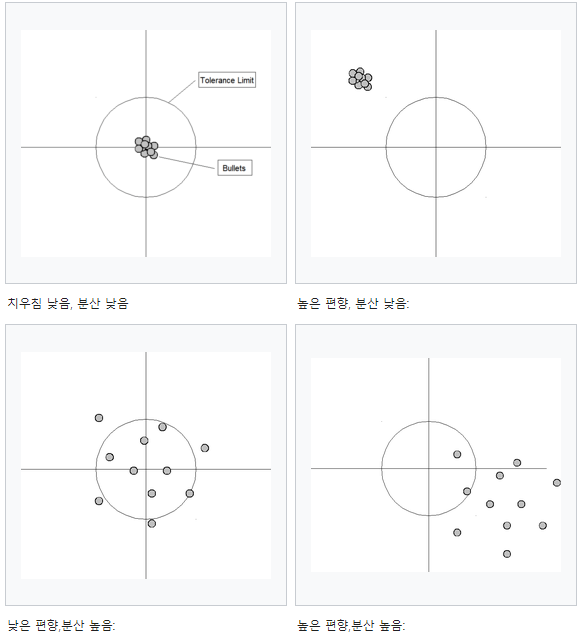

In [175]:
#from IPython.display import display, Image
#display(Image(filename='./image/bias_and_variance.png'))

[(Source: Wiki)](https://ko.wikipedia.org/wiki/%ED%8E%B8%ED%96%A5-%EB%B6%84%EC%82%B0_%ED%8A%B8%EB%A0%88%EC%9D%B4%EB%93%9C%EC%98%A4%ED%94%84)

## Ensemble (앙상블) 기법
앙상블 기법에는 다양한 방법이 있습니다.

- Voting (투표) : 투표를 통해 결과 도출
- Bagging : 샘플을 다양하게 중복 생성
- Boosting : 이전 오차를 보완하며 가중치 부여
- Stacking : 여러 모델을 기반으로 meta 모델 생성

이와 같은 다양한 방법 중에서 이번 베이스라인에서는 앙상블 기법 중 Voting을 사용할 것입니다.

## Voting (투표)

Voting은 단어 뜻 그대로 투표를 통해 결정하는 방식입니다.
Voting은 Bagging과 투표방식이라는 점에서 유사하지만, 다음과 같은 큰 차이점이 있습니다.

- Voting은 다른 알고리즘 모델을 조합해서 사용합니다.
- Bagging은 같은 알고리즘 내에서 다른 sample 조합을 사용합니다.

즉, Voting은 서로 다른 알고리즘이 도출해 낸 결과물에 대하여 최종 투표하는 방식을 통해 최종 결과를 선택합니다.
Voting은 또 Hard Voting과 Soft Voting으로 나뉘게 됩니다.

- Hard Voting : 각 모델들의 결과물에 대한 최종 값을 투표를 해서 결정합니다.
- Soft Voting : 각 모델들의 결과물이 나올 확률 값이나 회귀 값을 평균을 내서 최종 값을 도출합니다.

마지막으로 정리하자면, 이번 베이스라인에서는 앙상블(Ensemble) 기법 중에서 Soft-Voting을 사용하여 더 나은 결과값을 도출해보겠습니다.

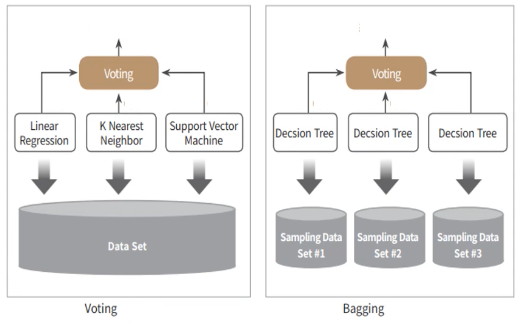

In [176]:
#from IPython.display import display, Image
#display(Image(filename='./image/ensemble_voting_bagging.png'))

[(Source: Velog)](https://velog.io/@jiselectric/Ensemble-Learning-Voting-and-Bagging-at6219ae)

## Soft-Voting 구현
이전에 학습시킨 3개의 모델들을 각각 추론하고,<br>
추론 결과들을 Soft-Voting 방식으로 결합하는 것을 간단하게 직접 구현해보겠습니다.

In [14]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if prediction is None:
        prediction = model.predict(test_x)
    else:
        prediction += model.predict(test_x)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
prediction /= len(models)

# 7. Dacon 대회에 제출하기 (Submission)

이제 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [11]:
# 제출용 Sample 파일을 불러옵니다
submission = pd.read_csv('./sample_submission.csv')
submission.head()

,id,Target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [12]:
submission['Target'] = prediction

# 데이터가 잘 들어갔는지 확인합니다
submission

,id,Target
0,1,9.583503
1,2,12.709410
2,3,5.669241
3,4,11.161924
4,5,9.971269
...,...,...
2919,2920,4.281635
2920,2921,7.578078
2921,2922,9.498796
2922,2923,9.696018


In [13]:
submission.to_csv('submit.csv', index=False)